In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [4]:
import pathlib
data_dir = pathlib.Path('C:\\Navneet\\TensorFlowPlayground\\tensorflow-keras\\datasets\\flower_photos')

In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


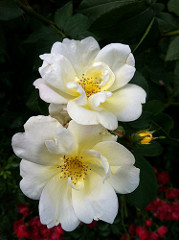

In [7]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

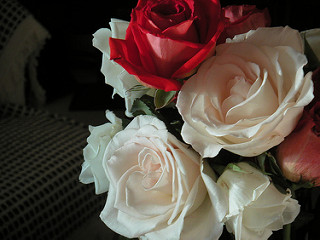

In [8]:
PIL.Image.open(str(roses[1]))

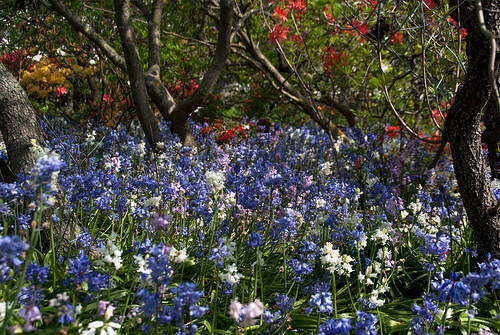

In [9]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[1]))

# CREATING DATASET

In [10]:
batch_size = 32
img_height = 180
img_width = 180

In [11]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [12]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)


Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [13]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


# VISUALISING DATA

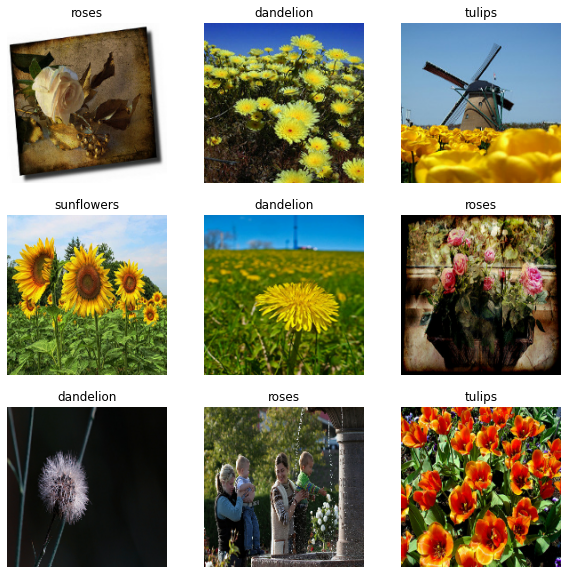

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)      
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [15]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break


(32, 180, 180, 3)
(32,)


In [16]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [17]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [18]:
normalized_ds = train_ds.map(lambda x,y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


# CREATING THE MODEL


In [20]:
num_classes = 5

model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)),
    layers.Conv2D(16,3, padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32,3, padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [21]:
model.compile(optimizer='adam',metrics=['accuracy'],loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [23]:
epochs=10
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/10
92/92 [==============================] - 75s 811ms/step - loss: 1.3579 - accuracy: 0.4114 - val_loss: 1.0633 - val_accuracy: 0.5640
Epoch 2/10
92/92 [==============================] - 60s 652ms/step - loss: 1.0221 - accuracy: 0.5913 - val_loss: 0.9784 - val_accuracy: 0.5954
Epoch 3/10
92/92 [==============================] - 61s 661ms/step - loss: 0.8258 - accuracy: 0.6778 - val_loss: 0.9155 - val_accuracy: 0.6281
Epoch 4/10
92/92 [==============================] - 63s 683ms/step - loss: 0.6455 - accuracy: 0.7606 - val_loss: 1.0382 - val_accuracy: 0.6076
Epoch 5/10
92/92 [==============================] - 64s 700ms/step - loss: 0.4143 - accuracy: 0.8522 - val_loss: 1.0534 - val_accuracy: 0.6471
Epoch 6/10
92/92 [==============================] - 65s 702ms/step - loss: 0.2742 - accuracy: 0.9091 - val_loss: 1.2685 - val_accuracy: 0.6553
Epoch 7/10
92/92 [==============================] - 60s 654ms/step - loss: 0.1683 - accuracy: 0.9462 - val_loss: 1.4392 - val_accuracy: 0.6499

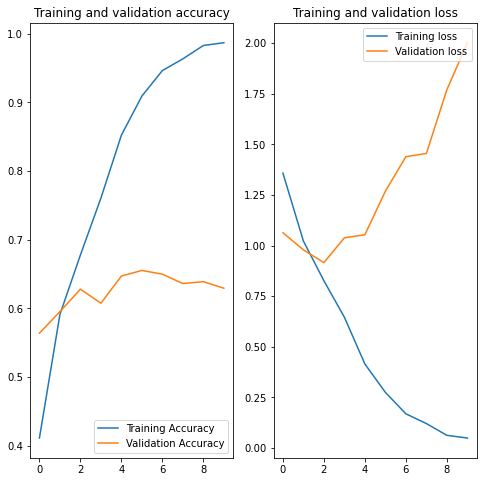

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and validation accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training loss')
plt.plot(epochs_range, val_loss, label='Validation loss')
plt.legend(loc='upper right')
plt.title('Training and validation loss')
plt.show()



In [25]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width,3)),
        layers.experimental.preprocessing.RandomRotation(0.1),
        layers.experimental.preprocessing.RandomZoom(0.1),
    ]
)

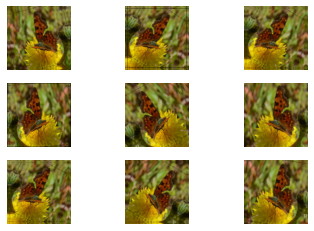

In [27]:
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3,3,i+1)
        plt.imshow(augmented_images[0].numpy().astype('uint8'))
        plt.axis('off')


In [28]:
model = Sequential([
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(16,3,padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64,3,padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [29]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [30]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_3 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [31]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 44s 475ms/step - loss: 1.2500 - accuracy: 0.4768 - val_loss: 1.0821 - val_accuracy: 0.5668
Epoch 2/15
92/92 [==============================] - 47s 516ms/step - loss: 1.0101 - accuracy: 0.5967 - val_loss: 0.9193 - val_accuracy: 0.6444
Epoch 3/15
92/92 [==============================] - 50s 542ms/step - loss: 0.9121 - accuracy: 0.6502 - val_loss: 0.8487 - val_accuracy: 0.6785
Epoch 4/15
92/92 [==============================] - 49s 533ms/step - loss: 0.8745 - accuracy: 0.6621 - val_loss: 0.8430 - val_accuracy: 0.6866
Epoch 5/15
92/92 [==============================] - 53s 572ms/step - loss: 0.8153 - accuracy: 0.6849 - val_loss: 0.8048 - val_accuracy: 0.6962
Epoch 6/15
92/92 [==============================] - 50s 548ms/step - loss: 0.7693 - accuracy: 0.7064 - val_loss: 0.8148 - val_accuracy: 0.6676
Epoch 7/15
92/92 [==============================] - 50s 543ms/step - loss: 0.7414 - accuracy: 0.7248 - val_loss: 0.7723 - val_accuracy: 0.7044

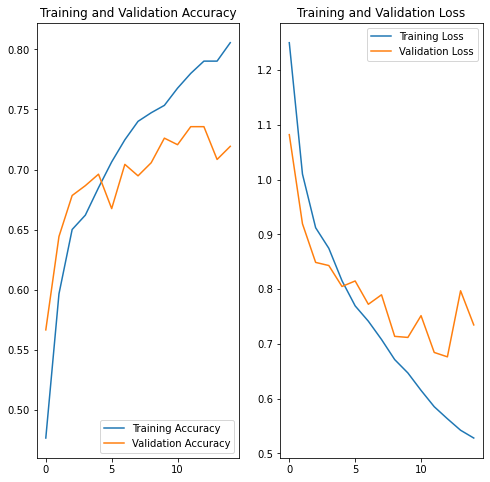

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [33]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

122880/117948 [===============================] - 0s 0us/step
This image most likely belongs to sunflowers with a 95.87 percent confidence.
